### Import modul

In [1]:
!pip install googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
  Obtaining dependency information for httpx==0.13.3 from https://files.pythonhosted.org/packages/54/b4/698b284c6aed4d7c2b4fe3ba5df1fcf6093612423797e76fbb24890dd22f/httpx-0.13.3-py3-none-any.whl.metadata
  Obtaining dependency information for hstspreload from https://files.pythonhosted.org/packages/05/f3/f0c098cce4f5dd11316f1f9cf63fd760320a6c1918741870360039ef6c08/hstspreload-2024.4.1-py3-none-any.whl.metadata
  Obtaining dependency information for chardet==3.* from https://files.pythonhosted.org/packages/bc/a9/01ffebfb562e4274b6487b4bb1ddec7ca55ec7510b22e4c51f14098443b8/chardet-3.0.4-py2.py3-none-any.whl.metadata
  Obtaining dependency information for idna==2.* from https://files.pythonhosted.org/packages/a2/38/928ddce2273eaa564f6f50de919327bf3a00f091b5baba8dfa9460f3a8a8/idna-2.10-py2.py3-none-any.whl.metadata
  Obtaining dependency information for rfc3986<2,>=1.3 from https://files.pythonhosted.org/packages/c4/e5/63ca2c4edf4e00657584608bee1001

In [2]:
from googletrans import Translator

In [3]:
import numpy as np
import os
import pickle
import tensorflow
from tqdm.notebook import tqdm 
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, Embedding, Dropout, add
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
inceptionv3_lstm = load_model('/kaggle/input/model-res/model_InceptionV3_LSTM_epoch44.h5')
resnet101_lstm = load_model('/kaggle/input/model-res/model_ResNet101_LSTM_epoch44.h5')
inceptionv3_bilstm = load_model('/kaggle/input/model-res/model_InceptionV3_BiLSTM_epoch44.h5')
resnet101_bilstm = load_model('/kaggle/input/model-res/model_ResNet101_BiLSTM_epoch44.h5')

In [5]:
direktori_utama = '/kaggle/input/flickr8k'
direktori_kerja = '/kaggle/working'
direktori_deskripsi = '/kaggle/input/caption-fix'

### Buka file gambar yang telah diterjemahkan

In [6]:
with open(os.path.join(direktori_deskripsi, 'caption_sunda.txt'), 'r') as f:
    next(f)
    file_deskripsi = f.read()

#### mapping

In [7]:
# membuat mapping antara gambar dengan deskripsi gambar
mapping = {}
# membaca baris pada file deskripsi gambar 
for line in tqdm(file_deskripsi.split('\n')):
    # membagi bari dengan koma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    id_gambar, deskripsi = tokens[0], tokens[1:]
    # menghapus jenis ekstensi pada nama gambar
    id_gambar = id_gambar.split('.')[0]
    # mengkonversi dari list ke string
    deskripsi = " ".join(deskripsi)
    # membuat list 
    if id_gambar not in mapping:
        mapping[id_gambar] = []
    # menyimpan deskripsi gambar
    mapping[id_gambar].append(deskripsi)
    
len(mapping)

  0%|          | 0/40454 [00:00<?, ?it/s]

8091

In [8]:
def clean(mapping):
    for key, list_deskripsi in mapping.items():
        for i in range(len(list_deskripsi)):
            # menggunakan satu deskripsi
            deskripsi = list_deskripsi[i]
            # langkah pre-processing
            # mengkonversi ke huruf kecil
            deskripsi = deskripsi.lower()
            # menghapus digit, karatkter spesial, dll.,
            deskripsi = deskripsi.replace('[^A-Za-z]', '')
            # menghapus spasi berlebihan
            deskripsi = deskripsi.replace('\s+', ' ')
            # menghapus titik
            deskripsi = deskripsi.replace('.', '')
            # menambahkan tanda start dan end pada kalimat deskripsi gambar
            deskripsi = 'start ' + " ".join([kata for kata in  deskripsi.split() if len(kata)>1]) + ' end'
            list_deskripsi[i] = deskripsi

In [9]:
clean(mapping)
semua_deskripsi = []
for key in mapping:
    for deskripsi in mapping[key]:
        semua_deskripsi.append(deskripsi)
len(semua_deskripsi)
semua_deskripsi[:10]

['start hiji budak leutik maké gaun pink naék kana tangga asup ka imah end',
 'start hiji budak rek asup ka wangunan kai end',
 'start hiji jalma rada naék ka imah kai end',
 'start hiji jalma rada naék tangga ka imah kai dirina end',
 'start hiji jalma maké baju pink naék tangga bade ka kabin kai end',
 'start anjing hideung sareng anjing belang gelut end',
 'start anjing hideung sareng anjing anu warna silih usil di jalan end',
 'start anjing hideung sareng anjing bodas kalayan bintik coklat anu silih tingali di jalan end',
 'start dua anjing béda besar anu silih tingali di jalan end',
 'start dua anjing dina silih pindah ka trotoar end']

In [10]:
# tokenisasi kalimat
tokenizer = Tokenizer()
tokenizer.fit_on_texts(semua_deskripsi)
jumlah_kata = len(tokenizer.word_index)
# jumlah maksimum kata dari kalimat deskripsi gambar yang ada
max_length = max(len(deskripsi.split()) for deskripsi in semua_deskripsi)

In [11]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import InceptionV3

In [12]:
# membuka model ResNet101
resnet101 = ResNet101(weights='imagenet')
resnet101 = Model(inputs=resnet101.input, outputs=resnet101.layers[-2].output)

179648224/179648224 [==============================] - 2s 0us/step


In [13]:
# membuka model InceptionV3 model
inceptionv3 = InceptionV3()
inceptionv3 = Model(inputs=inceptionv3.inputs, outputs=inceptionv3.layers[-2].output)

96112376/96112376 [==============================] - 1s 0us/step


In [14]:
def fe_resnet101(nama_gambar):
    direktori = os.path.join(direktori_utama, 'Images/')
    alamat_gambar = direktori + nama_gambar
    gambar = load_img(alamat_gambar, target_size=(224, 224))
    # mengkompersi pixel gambar ke dalam array dengan bantuan numpy
    gambar = img_to_array(gambar)
    # mengantur dimensi gambar 
    gambar = gambar.reshape((1, gambar.shape[0], gambar.shape[1], gambar.shape[2]))
    # pre-processing gambar supaya sesuai dengan model
    gambar = tensorflow.keras.applications.resnet.preprocess_input(gambar)
    # extract features
    feature_resnet101 = resnet101.predict(gambar, verbose=0)
    return feature_resnet101

In [15]:
def fe_inceptionv3(nama_gambar):
    direktori = os.path.join(direktori_utama, 'Images/')
    alamat_gambar = direktori + nama_gambar
    gambar_i = load_img(alamat_gambar, target_size=(299, 299))
    # mengkompersi pixel gambar ke dalam array dengan bantuan numpy
    gambar_i = img_to_array(gambar_i)
    # mengantur dimensi gambar 
    gambar_i = gambar_i.reshape((1, gambar_i.shape[0], gambar_i.shape[1], gambar_i.shape[2]))
    # pre-processing gambar supaya sesuai dengan model
    gambar_i = tensorflow.keras.applications.inception_v3.preprocess_input(gambar_i)
    # extract features
    feature_inception = inceptionv3.predict(gambar_i, verbose=0)
    return feature_inception

In [16]:
# fungsi menkompersi index ke kata
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
          return word
    return None

# fungsi untuk membuat kalimat deskripsi gambar 
def predict_caption(model, gambar, tokenizer, max_length):
    # tambahkan tanda awal untuk proses pembuatan deskripsi gambar
    kalimat_prediksi = 'start'
    # ulangi sepanjang panjang urutan maksimal kata dalam kalimat
    for i in range(max_length):
        # urutan input 
        urutan = tokenizer.texts_to_sequences([kalimat_prediksi])[0]
        # pad urutannya
        urutan = pad_sequences([urutan], max_length)
        # memprediksi kata selanjutnya
        yhat = model.predict([gambar, urutan], verbose=0)
        # dapatkan indeks dengan probabilitas tinggi
        yhat = np.argmax(yhat)
        # ubah indeks menjadi kata
        kata = idx_to_word(yhat, tokenizer)
        # berhenti jika kata tidak ditemukan
        if kata is None:
            break
        # tambahkan kata sebagai masukan untuk menghasilkan kata berikutnya
        kalimat_prediksi += " " + kata
        # berhenti jika kita mencapai tanda akhir
        if kata == 'end':
            break
    return kalimat_prediksi

In [17]:
# fungsi terjemahan dari inggris ke indonesia
def translate_to_indonesia(text):
    translator = Translator()
    translation = translator.translate(text, src='su', dest='id')
    return translation.text

# fungsi membuat caption yang mencetak kalimat sebenarnya dan prediksinya
def generate_caption(nama_gambar):
    # membuka gambar
    nama_gambar = nama_gambar
    id_gambar = nama_gambar.split('.')[0]
    alamat_gambar = os.path.join(direktori_utama, "Images/", nama_gambar)
    gambar = Image.open(alamat_gambar)
    list_deskripsi = mapping[id_gambar]
    print('---------------------Sebenarnya---------------------')
    for deskripsi in list_deskripsi:
        print(deskripsi)
    feature_resnet101 = fe_resnet101(nama_gambar)
    feature_inception = fe_inceptionv3(nama_gambar)
    # prediksi deskripsi gambar
    y_pred = predict_caption(resnet101_lstm, feature_resnet101, tokenizer, max_length)
    y_pred_inceptionV3_LSTM = predict_caption(inceptionv3_lstm, feature_inception, tokenizer, max_length)
    y_pred_inceptionV3_BiLSTM = predict_caption(inceptionv3_bilstm, feature_inception, tokenizer, max_length)
    y_pred_ResNet101_BiLSTM = predict_caption(resnet101_bilstm, feature_resnet101, tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print('Hasil ResNet101 LSTM: ' + y_pred)
    print('Hasil InceptionV3 LSTM: ' + y_pred_inceptionV3_LSTM)
    print('Hasil ResNet101 BiLSTM: ' + y_pred_ResNet101_BiLSTM)
    print('Hasil InceptionV3 BiLSTM: ' + y_pred_inceptionV3_BiLSTM)
    indo_ResNet101 = y_pred.replace('start','')
    indo_ResNet101 = indo_ResNet101.replace('end','.')
    print('Terjemahan hasil prediksi ResNet101 LSTM: '+translate_to_indonesia(indo_ResNet101))
    indo_inceptionV3_LSTM = y_pred_inceptionV3_LSTM.replace('start','')
    indo_inceptionV3_LSTM = indo_inceptionV3_LSTM.replace('end','.')
    print('Terjemahan hasil prediksi InceptionV3 LSTM: '+translate_to_indonesia(indo_inceptionV3_LSTM))
    indo_ResNet101_BiLSTM = y_pred_ResNet101_BiLSTM.replace('start','')
    indo_ResNet101_BiLSTM = indo_ResNet101_BiLSTM.replace('end','.')
    print('Terjemahan hasil prediksi ResNet101 BiLSTM: '+translate_to_indonesia(indo_ResNet101_BiLSTM))
    indo_inceptionV3_BiLSTM = y_pred_inceptionV3_BiLSTM.replace('start','')
    indo_inceptionV3_BiLSTM = indo_inceptionV3_BiLSTM.replace('end','.')
    print('Terjemahan hasil prediksi InceptionV3 BiLSTM: '+translate_to_indonesia(indo_inceptionV3_BiLSTM))
    plt.imshow(gambar)

---------------------Sebenarnya---------------------
start pamaén maén bal biru keur ngudag pamaén bal hideung bodas end
start budak jalma baju bodas parantos labuh nalika mojangbaju biru pikeun maén bal end
start budak jalma maén bal end
start dua jalma maké saragam bal maén bal end
start dua jalma ngora dina tim anu béda maén bal di sawah end
--------------------Predicted--------------------
Hasil ResNet101 LSTM: start dua budak jalma di tim sabalikna anu bersaing pikeun bal maénbal end
Hasil InceptionV3 LSTM: start budak jalma maén bal end
Hasil ResNet101 BiLSTM: start budak jalma ngagem kaos biru sareng calana pondok biru najong bal maénbal end
Hasil InceptionV3 BiLSTM: start pamaén maén bal dina beureum maén bal end
Terjemahan hasil prediksi ResNet101 LSTM: Dua anak laki -laki di tim yang berlawanan yang bersaing untuk bola sepak.
Terjemahan hasil prediksi InceptionV3 LSTM: anak laki -laki sepak bola.
Terjemahan hasil prediksi ResNet101 BiLSTM: Anak -anak mengenakan kemeja biru da

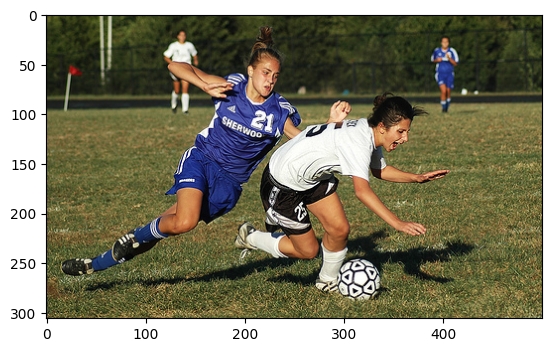

In [18]:
generate_caption('47871819_db55ac4699.jpg')

---------------------Sebenarnya---------------------
start dua kuda draf narik karanjang liwat salju end
start dua kuda coklat emas narik palaku anu disetir ku jalma ngagem jas biru end
start dua kuda anu narik jalma dina karanjang end
start dua kuda tarik gerbong anu disetir ku jalma dina salju katutupan salju katutup end
start dua kuda narik hiji gerbong anu disetir ku jalma anu seuri end
--------------------Predicted--------------------
Hasil ResNet101 LSTM: start dua kuda draf narik karanjang liwat salju end
Hasil InceptionV3 LSTM: start dua kuda narik jalma dina karanjang end
Hasil ResNet101 BiLSTM: start tilu kuda draf end
Hasil InceptionV3 BiLSTM: start dua kuda tarik gerbong anu disetir ku jalma anu ngagem jaket wungu sareng bodas end
Terjemahan hasil prediksi ResNet101 LSTM: Dua draft draft menarik kereta di atas salju.
Terjemahan hasil prediksi InceptionV3 LSTM: Dua kuda menarik orang di kereta.
Terjemahan hasil prediksi ResNet101 BiLSTM: tiga draft.
Terjemahan hasil prediksi

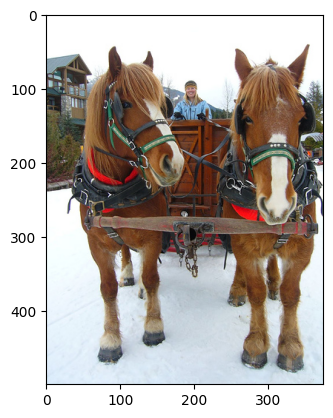

In [19]:
generate_caption('109202801_c6381eef15.jpg')

---------------------Sebenarnya---------------------
start penjaga ngagem hélem biru sareng lampu anu napel dina tali dina raray batu end
start saurang jalma naék témbok taringgul end
start jelema naék batu end
start jalma dina batu end
start jalma anu hélem biru sareng calana ungu mangrupikeun naék batu end
--------------------Predicted--------------------
Hasil ResNet101 LSTM: start hiji jalma ngagem hélem biru sareng kaos beureum naék témbok batu ageung end
Hasil InceptionV3 LSTM: start hiji jalma ngagem topi hideung sareng kaos bodas anu napel dina tali panjang end
Hasil ResNet101 BiLSTM: start hiji jalma ngagem hélem mimiti naék batu end
Hasil InceptionV3 BiLSTM: start hiji jalma ngagem topi sareng kacasoca ngawangun héjo end
Terjemahan hasil prediksi ResNet101 LSTM: Seseorang mengenakan helm biru dan kemeja merah naik dinding batu besar.
Terjemahan hasil prediksi InceptionV3 LSTM: Seseorang yang mengenakan topi hitam dan kemeja putih yang melekat pada tali panjang.
Terjemahan has

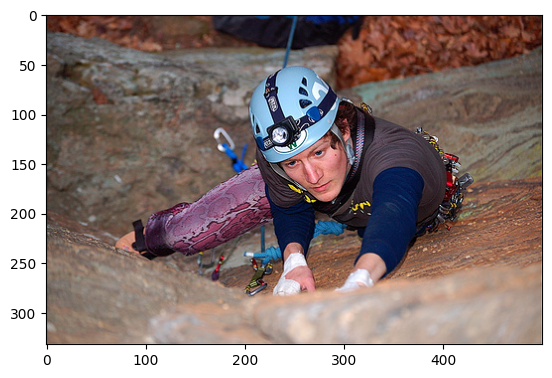

In [20]:
generate_caption('111537222_07e56d5a30.jpg')

---------------------Sebenarnya---------------------
start manuk hideung sareng bodas tuang siki kaluar tina leungeun batur end
start manuk hideung sareng bodas nangtung dina panangan end
start manuk leutik calik dina leungeun jalma sareng tuang siki end
start manuk hideung sareng bodas nangtung dina panangan batur nyekel siki kembang end
start manuk leutik nembé ramo leungeun panangan anu nyekel siki end
--------------------Predicted--------------------
Hasil ResNet101 LSTM: start hiji jalma nembé ramo dina leungeun batur end
Hasil InceptionV3 LSTM: start manuk bodas sareng spidging héjo dina beuheung sareng rambut coklat sareng rambut coklat poék anu mawa sapotong dina panangan end
Hasil ResNet101 BiLSTM: start manuk hideung sareng bodas nangtung dina suku tukangeun na end
Hasil InceptionV3 BiLSTM: start hiji budak ngora nangtung dina suku tukangeun na kaluar tina hiji danau end
Terjemahan hasil prediksi ResNet101 LSTM: Satu orang hanya jari di tangan seseorang.
Terjemahan hasil pred

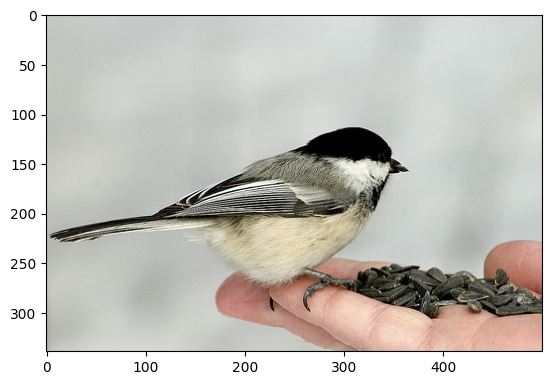

In [21]:
generate_caption('111766423_4522d36e56.jpg')

---------------------Sebenarnya---------------------
start rasa motor anu kompetitif nyiapkeun kanggo ngadamel kénca kénca sapanjang jalan anu diaspal end
start saurang jalma anu nganggo motor sareng nomer di dinya end
start supir mobil motor di kénca end
start motor sareng nomer lima di payuneun diangkat ku supir ngagem hélem beureum end
start pabalap motor profésional ngintunkeun juru end
--------------------Predicted--------------------
Hasil ResNet101 LSTM: start jalma anu nangtung dina motor beureum na dina udara end
Hasil InceptionV3 LSTM: start hiji jalma dina motor anu nganggo motor dina motor end
Hasil ResNet101 BiLSTM: start jalma anu ngagem hélem kulit anu numpak sapédah beureum sareng beureum end
Hasil InceptionV3 BiLSTM: start bandéra nomer pembalap nunggang mobil end
Terjemahan hasil prediksi ResNet101 LSTM: Orang yang berdiri di atas sepeda motor merah di udara.
Terjemahan hasil prediksi InceptionV3 LSTM: Satu orang dalam sepeda motor dengan sepeda motor di motor.
Terjem

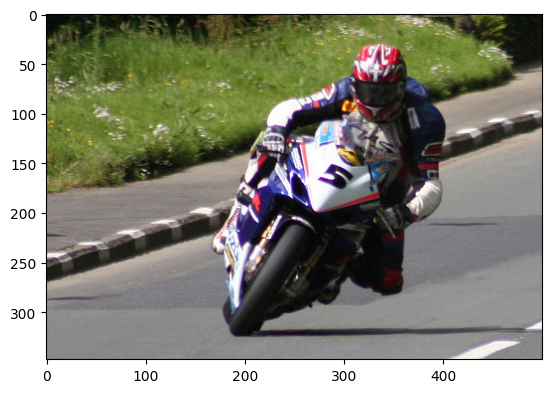

In [22]:
generate_caption('161669933_3e7d8c7e2c.jpg')

---------------------Sebenarnya---------------------
start dilas tina jalma kolot kalayan kacasoca nyarios end
start hiji jalma ngagem kaos biru sareng kacasoca end
start hiji jalma nganggo kacasoca hideung sareng kumis anu diajak ngobrol end
start hiji jalma nganggo kacasoca sareng kumis aya di tengah kalimat end
start hiji jalma kolot kalayan kacasoca ngintunkeun kaméra end
--------------------Predicted--------------------
Hasil ResNet101 LSTM: start hiji jalma botak ngagem kaos biru anu nyekel cangkir és end
Hasil InceptionV3 LSTM: start hiji jalma ngagem kaos pola anu disukakeun botol bir end
Hasil ResNet101 BiLSTM: start hiji jalma ngagem kacasoca nyarios di hareup kaméra end
Hasil InceptionV3 BiLSTM: start hiji jalma ngagem topi hideung sareng jaket panon gedé nyepeng sapotong kertas imut end
Terjemahan hasil prediksi ResNet101 LSTM: Seorang pria botak mengenakan kemeja biru yang menampung secangkir es.
Terjemahan hasil prediksi InceptionV3 LSTM: Seseorang mengenakan kemeja pola 

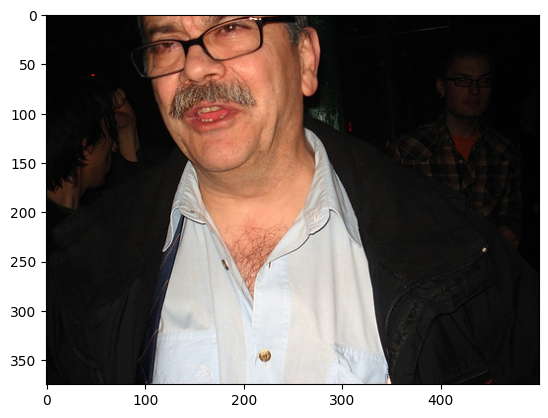

In [23]:
generate_caption('307327914_f98f576adb.jpg')

---------------------Sebenarnya---------------------
start hiji anak lumpat kana hiji danau di daérah leuweung bari anak anu sanés maén di basisir end
start anak lumpat kana cai nganggo sapatu na end
start hiji budak lumpat kana kolam renang cai end
start budak leutik di sapatu ngajleng kana cai end
start jalma nyandak ngora kana cai kalayan sapatu na end
--------------------Predicted--------------------
Hasil ResNet101 LSTM: start hiji jalma ngagem calana pondok pink sareng calana pondok biru naék kana cai end
Hasil InceptionV3 LSTM: start hiji jalma ngagem topi baseball anu leumpang di pasir end
Hasil ResNet101 BiLSTM: start budak jalma ngagem kaos konéng sareng calana pondok biru maén dina cai end
Hasil InceptionV3 BiLSTM: start hiji jalma ngagem pakéan plas anu muter pikeun hiji obyék bari nangtung dina cai end
Terjemahan hasil prediksi ResNet101 LSTM: Seseorang mengenakan celana merah muda dengan celana biru naik ke air.
Terjemahan hasil prediksi InceptionV3 LSTM: Seseorang mengen

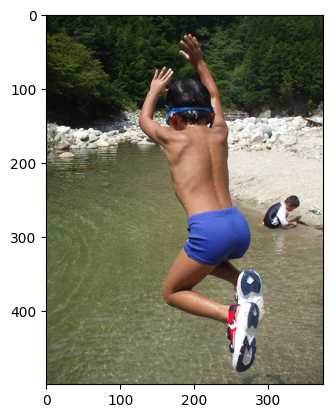

In [24]:
generate_caption('1159574340_99ba8c3c59.jpg')

---------------------Sebenarnya---------------------
start parahu di hiji danau end
start baki busheberer lumpat di udara end
start cai ngalaksanakeun trik end
start jalma waterskiing henteu jungkir balik tukangeun end
start dimerseki ngagaduhan jungkir balik tukangeun kapal end
--------------------Predicted--------------------
Hasil ResNet101 LSTM: start dua urang numpak kapal sareng kapal di laut end
Hasil InceptionV3 LSTM: start jalma anu ngagurilap muka udara pikeun nyekel hiji hal dina cai end
Hasil ResNet101 BiLSTM: start parahu sareng kapal anu napel dina tali beureum sareng bodas end
Hasil InceptionV3 BiLSTM: start jalma ngapung mancing end
Terjemahan hasil prediksi ResNet101 LSTM: Dua orang naik perahu dan kapal di laut.
Terjemahan hasil prediksi InceptionV3 LSTM: Orang yang bersinar membuka udara untuk menangkap sesuatu di dalam air.
Terjemahan hasil prediksi ResNet101 BiLSTM: Sebuah perahu dan kapal yang melekat pada tali merah dan putih.
Terjemahan hasil prediksi InceptionV

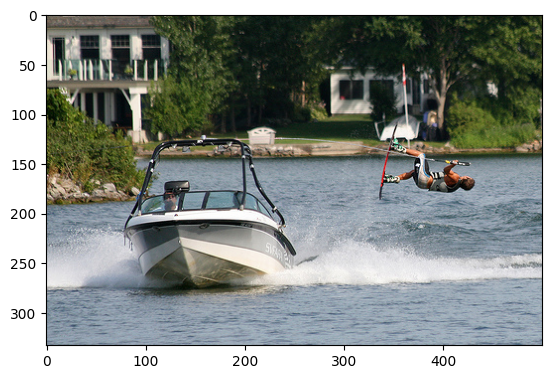

In [25]:
generate_caption('1280147517_98767ca3b3.jpg')

---------------------Sebenarnya---------------------
start hiji jalma di kaos baju sareng dasi nangtung di hareupeun donat penjual anu ngajual end
start jalma anu nangtung diantara restorurures di hareupeun toko donat end
start hiji jalma nganggo kaos bodas sareng dasi anu nangtung di trotoar antara halangan semén end
start hiji jalma anu nangtung di jalan end
start jalma nangtung antara halangan betcrit caket toko donat end
--------------------Predicted--------------------
Hasil ResNet101 LSTM: start hiji jalma ngagem topi rajut maca ka kaméra end
Hasil InceptionV3 LSTM: start jalma leumpang di trotoar end
Hasil ResNet101 BiLSTM: start hiji jalma ngagem jaket biru sareng topi koboy maca kertas end
Hasil InceptionV3 BiLSTM: start hiji jalma ngagem jaket hideung sareng topi nangtung di hareup témbok bata end
Terjemahan hasil prediksi ResNet101 LSTM: Seseorang memakai topi rajutan untuk dibaca ke kamera.
Terjemahan hasil prediksi InceptionV3 LSTM: Orang -orang berjalan di trotoar.
Terjem

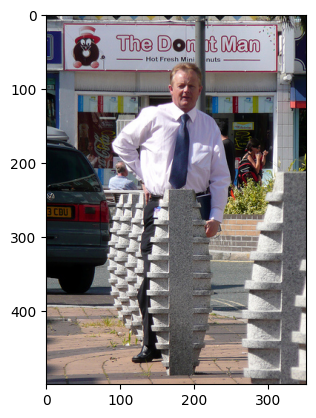

In [26]:
generate_caption('1342780478_bacc32344d.jpg')

---------------------Sebenarnya---------------------
start tilu bikang ngagem tapak suku nangtung babarengan end
start tilu jalma muslim milarian kaméra end
start tilu jalma di pakéan sareng holongan sirah di luar end
start tilu jalma dina suku sirah nalungtik kaméra end
start tilu jalma kalayan hemang sirah sareng rok panjang end
--------------------Predicted--------------------
Hasil ResNet101 LSTM: start tilu budak jalma ngagem pakéan sareng holongan sirah di luar end
Hasil InceptionV3 LSTM: start tilu jalma asia nangtung di luar gedong beureum end
Hasil ResNet101 BiLSTM: start hiji jalma sareng jalma ngora nangtung ogé nyekel alat anu sanés end
Hasil InceptionV3 BiLSTM: start hiji budak ngagem pakéan biru caang nangtung di hareupeun wangunan sareng jalma ngagem jilbab pink end
Terjemahan hasil prediksi ResNet101 LSTM: Tiga anak laki -laki mengenakan gaun dan kepala kepala di luar.
Terjemahan hasil prediksi InceptionV3 LSTM: Tiga orang Asia berdiri di luar gedung merah.
Terjemahan h

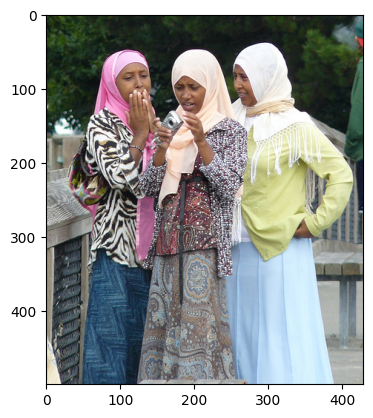

In [27]:
generate_caption('1339596997_8ac29c1841.jpg')